# Clickbait spoiling 🖱️
Task description: https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html (task 2)

Data: https://zenodo.org/record/6362726#.YsbdSTVBzrk

In [1]:
import pandas as pd
from transformers import pipeline

from src.data import read_data, read_spoilers, read_data_classification, save_df_to_jsonl
from src.spoiler_classification import get_tokenized_dataset, prepare_training
from src.qa_model import run_qa_model
from src.evaluation import eval_task_2, plot_scores

## Data preparation

In [2]:
train = read_data('data/train.jsonl')

In [3]:
train.head()

,uuid,title,question,context,spoiler
0,0af11f6b-c889-4520-9372-66ba25cb7657,"Wes Welker Wanted Dinner With Tom Brady, But P...","Wes Welker Wanted Dinner With Tom Brady, But P...","Wes Welker Wanted Dinner With Tom Brady, But P...",[how about that morning we go throw?]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,Hole In Ozone Layer Expected To Make Full Reco...,NASA sets date for full recovery of ozone hole,Hole In Ozone Layer Expected To Make Full Reco...,[2070]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,Intellectual Stimulation Trumps Money For Empl...,This is what makes employees happy -- and it's...,Intellectual Stimulation Trumps Money For Empl...,[intellectual stimulation]
3,31ecf93c-3e21-4c80-949b-aa549a046b93,"‘Follow your passion’ is wrong, here are 7 hab...",Passion is overrated — 7 work habits you need ...,"‘Follow your passion’ is wrong, here are 7 hab...",[Purpose connects us to something bigger and i...
4,31b108a3-c828-421a-a4b9-cf651e9ac859,Revealed: The perfect way to cook rice so that...,The perfect way to cook rice so that it's perf...,Revealed: The perfect way to cook rice so that...,[in a rice cooker]


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   uuid      3200 non-null   object
 1   title     3200 non-null   object
 2   question  3200 non-null   object
 3   context   3200 non-null   object
 4   spoiler   3200 non-null   object
dtypes: object(5)
memory usage: 125.1+ KB


## Spoiler-type classification
The approach based on [Clickbait Spoiling via Question Answering and Passage Retrieval](https://aclanthology.org/2022.acl-long.484) (Hagen et al., ACL 2022) where firstly a spoiler is classified as "phrase", "passage", "multi" and depending on the classification either QA or PR problem is solved.

Here, we'll use DeBERTa for the classification (we will classify spoiler to either "phrase" or "passage"["multi" treated as passage - multi passage originally]).

## DeBERTa: Decoding-Enhanced BERT With Disentangled Attention (Microsoft)
Two key mechanisms: **disentangled attention** and an **enhanced mask decoder**. Reccommended for long sequences (our case 👍)


**Disentangled attention** differs from all existing approaches in that each input word is represented using two separate vectors that encode a word’s content and position, respectively. The key difference is that instead of adding the two vectors we treat them separately throughout the network. These relative position embeddings are shared across all the layers of the transformer as inputs and the self-attention layer not only uses the query and key transformation on the context embeddings but also has separate matrices for the transformation for these positional embeddings.

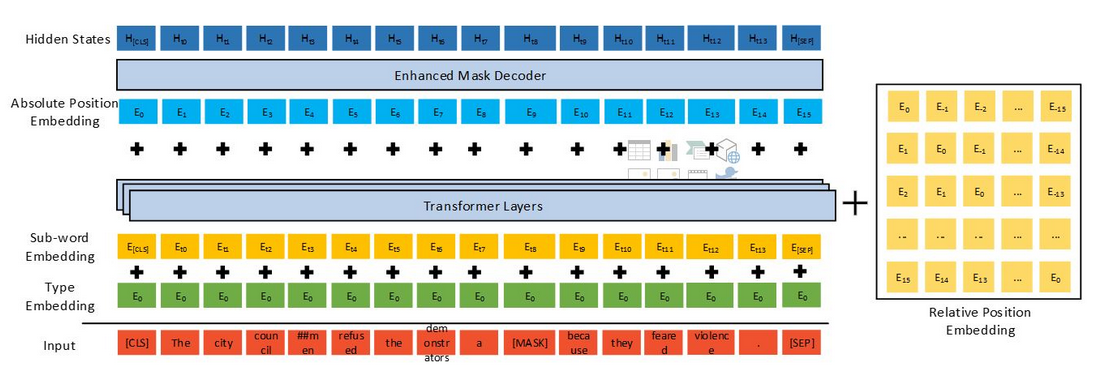


**Enhanced mask decoder** - to give the model some context of the actual positions, the authors add them right after all the transformer layers but before the softmax layer for masked token prediction. Hence, DeBERTa captures the relative positions in all the transformer layers and only uses absolute positions as complementary information when decoding the masked words. Thus, the name enhanced masked decoder.

[*source: wandb.ai*](https://wandb.ai/akshayuppal12/DeBERTa/reports/The-Next-Generation-of-Transformers-Leaving-BERT-Behind-With-DeBERTa--VmlldzoyNDM2NTk2)

### Data Preparation

In [5]:
train_classification = read_data_classification('data/train.jsonl')
display(train_classification.head())

validation_classification = read_data_classification('data/validation.jsonl')

,context,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",0
1,NASA sets date for full recovery of ozone hole...,1
2,This is what makes employees happy -- and it's...,1
3,Passion is overrated — 7 work habits you need ...,0
4,The perfect way to cook rice so that it's perf...,1


In [6]:
train_dataset = get_tokenized_dataset(train_classification)
validation_dataset = get_tokenized_dataset(validation_classification)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [7]:
small_train_dataset = train_dataset.shuffle(seed=42).select(range(1000))
small_eval_dataset = validation_dataset.shuffle(seed=42).select(range(200))

In [8]:
trainer, model = prepare_training(small_train_dataset, small_eval_dataset)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.d

In [9]:
model

In [ ]:
trainer.train()

## Question Answering model
Firstly, we will verify existing approach - question answering pipeline with roberta-base-squad2 model.

In [5]:
qa_pipeline = pipeline(model="deepset/roberta-base-squad2")

Downloading:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

### Verify sample spoilers and assess accuracy
For now, simply check if real and generated spoiler intersect with at least one word.

In [20]:
score = []
preds = dict({"uuid" : [],
             "spoiler": []})

print("correct | generated spoiler | true spoiler")
for i, uuid, question, context, spoiler in zip(range(10), train.uuid, train.question, train.context, train.spoiler):
    answer = qa_pipeline(
        question=question,
        context=context,
    )
    if any(word in spoiler[0].split() for word in answer['answer'].split()):
        score.append(1)
    else:
        score.append(0)
    print(score[i], answer['answer'], spoiler)
    preds["uuid"].append(uuid)
    preds["spoiler"].append(answer['answer'])

pred_df = pd.DataFrame.from_dict(preds)
print(f"\nAccuracy: {sum(score)/len(score)}")

correct | generated spoiler | true spoiler
1 let’s go throw ['how about that morning we go throw?']
1 2070 ['2070']
0 money ['intellectual stimulation']
0 Adopting a peripheral perspective ['Purpose connects us to something bigger and in doing so makes us right sized', 'be ruthless with your "No’s."', 'Practice means greatness is doable ... one tiny step after another', 'planning of the SMART goal and number-crunching variety', 'Objectivity — the ability to see the world as it truly is']
0 I follow these steps ['in a rice cooker']
1 you'll have to buy new ones ["Apple says that if AirPods are lost or stolen, you'll have to buy new ones, just like any other Apple product."]
0 Is he constantly hungover ['"The more good games I had in them, the more I got used to them.']
1 -10 degrees Celsius," said Hänninen. ['rainbow colours in the sky and a halo spanning 360 degrees']
0 5/5 say yes ['Red wine is clearly the drink of choice if you are doing light to moderate drinking for your health, a

There is definitely room for improvement, some generated spoiler are perfectly correct, but some are totally missed.

## Evaluation
We will use script provided by SemEval23 organizers to evaluate our approaches. The scripts takes data in the form of JSONL file with columns `uuid` and `spoiler`.

The modules calculates two scores:
1. [BLEU](https://pl.wikipedia.org/wiki/BLEU): Quality is considered to be the correspondence between a machine's output and that of a human, the higher the better. The score takes values between 0 and 1.
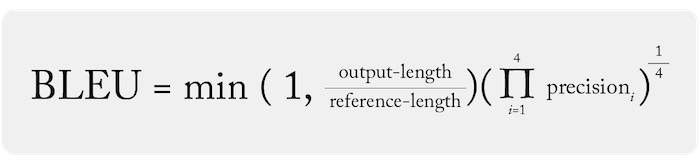
2. [BERT](https://github.com/Tiiiger/bert_score): Leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. The range is -1 to 1.
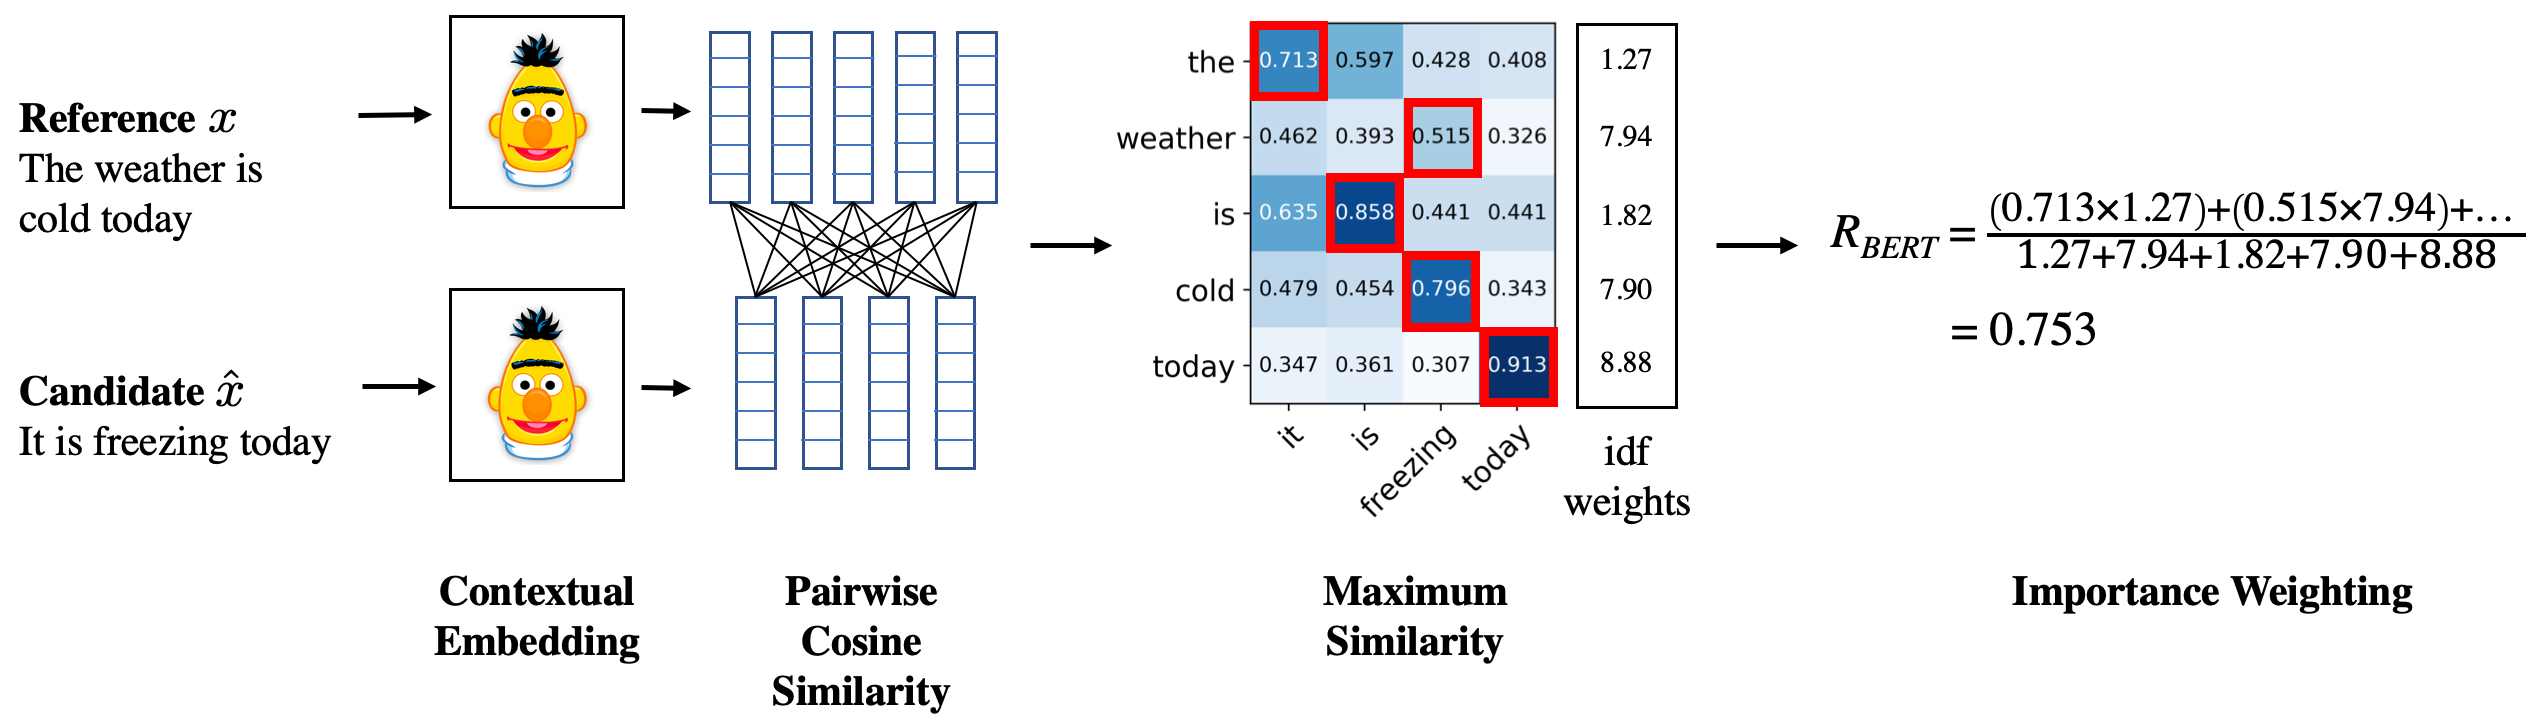

In [21]:
save_df_to_jsonl(train.iloc[:10], "data/test_true.jsonl")
save_df_to_jsonl(pred_df, "data/test_output.jsonl")

In [ ]:
scores = eval_task_2("data/test_output.jsonl", "data/test_true.jsonl")

In [11]:
print(scores)

measure{
  key: "result-size-all-spoilers"
  value: "3200"
}
measure{
  key: "bleu-score-all-spoilers"
  value: "0.25914445523695245"
}
measure{
  key: "bert-score-all-spoilers"
  value: "0.8715313076972961"
}
measure{
  key: "missing-predictions-all-spoilers"
  value: "0"
}


## RoBERTa
Question answering taking spoiler type into account.

In [2]:
run_qa_model("data/validation.jsonl", "data/preds.jsonl")

Using GPU for pipeline
Using GPU for pipeline


  1%|▏         | 10/800 [00:03<02:44,  4.80it/s]/home/zuzg/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 800/800 [02:39<00:00,  5.03it/s]


In [ ]:
scores = eval_task_2("data/preds.jsonl", "data/validation.jsonl")

In [3]:
scores

{'result-size-all-spoilers': 800,
 'bleu-score-all-spoilers': 0.2833054912141546,
 'bert-score-all-spoilers': 0.8829432129859924,
 'missing-predictions-all-spoilers': 0,
 'result-size-phrase-spoilers': 335,
 'bleu-score-phrase-spoilers': 0.4776299651420253,
 'bert-score-phrase-spoilers': 0.9287846088409424,
 'missing-predictions-phrase-spoilers': 0,
 'result-size-passage-spoilers': 322,
 'bleu-score-passage-spoilers': 0.1800982175291465,
 'bert-score-passage-spoilers': 0.8525652289390564,
 'missing-predictions-passage-spoilers': 0,
 'result-size-multi-spoilers': 143,
 'bleu-score-multi-spoilers': 0.06046663359692279,
 'bert-score-multi-spoilers': 0.8439561128616333,
 'missing-predictions-multi-spoilers': 0}

/home/zuzg/nlp/clickbait-spoiling/src/evaluation.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


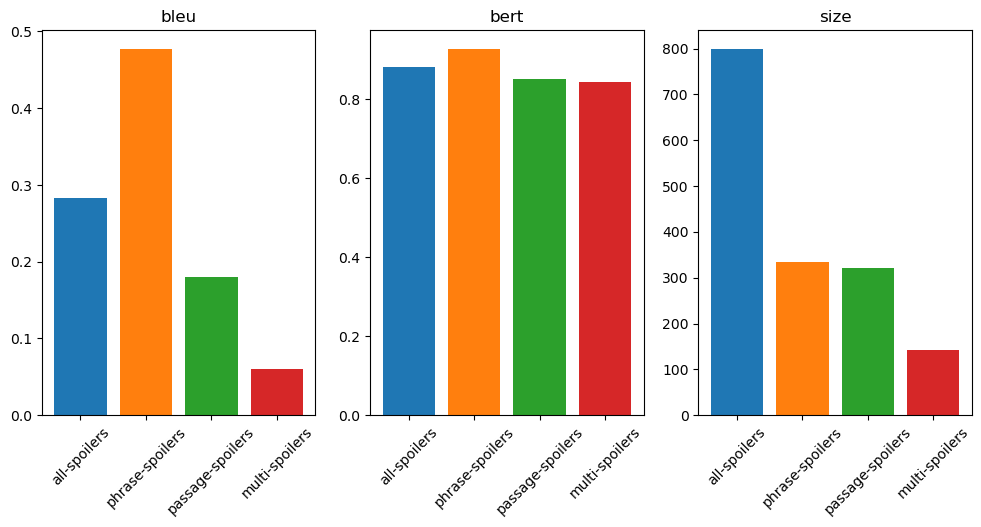

In [4]:
plot_scores(scores)

### Sample predictions

In [4]:
val = read_spoilers("data/validation.jsonl")
pd.set_option('display.max_colwidth', None)
val.head(10)

,uuid,spoiler
0,6dc7ddef-4e8e-4a6b-9296-526377518071,[some of the plot elements are so disturbing that they are making him feel sick]
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,"[""intentionally"", could transform a court case against Phoenix-area Sheriff Joe Arpaio from civil charges to a criminal prosecution]"
2,8091ba93-6376-473a-9117-01d6cf0507e4,[20%]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,"[Alan Rickman & Rupert Grint, CBGB]"
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,[a man who swallowed a 64GB microSD card and then pooped it into a strainer]
5,804ba7e2-2e3b-439b-9ee4-6827939c902d,[Sprite]
6,d636e94d-d27a-4366-b177-1299c266d7b5,[Smoky Paprika-Baked Garbanzo Beans]
7,cf3cb892-fb30-4210-a525-e5e7aa921082,"[McGonagall was appointed as Dumbledore’s assistant in 1956, not as his replacement.]"
8,a86850fc-047b-432b-bc85-5e198ff4527f,[All the scenes are actually in the movie]
9,ba35ffbc-1eba-4940-8c68-00eefecd2178,"[""I had fake relationships, fake fights. I don't care anymore, I can tell you.]"


In [5]:
pred = read_spoilers("data/preds.jsonl")
pred.head(10)

,uuid,spoiler
0,6dc7ddef-4e8e-4a6b-9296-526377518071,"[According to a post by Cawthon on the Five Nights at Freddy’s: Sister Location Steam page, the game is being delayed because it’s too dark]"
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,"[intentionally, """", criminal prosecution, , ]"
2,8091ba93-6376-473a-9117-01d6cf0507e4,[slightly smaller tip]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,"[Michael Gambon, Newcastle accent, Julie Walters, Alan, chocolate]"
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,"[The story is written in the first person by ""John Doe,"" who is apparently embarrassed by the incident and chose to remain anonymous]"
5,804ba7e2-2e3b-439b-9ee4-6827939c902d,[Sprite]
6,d636e94d-d27a-4366-b177-1299c266d7b5,[midnight]
7,cf3cb892-fb30-4210-a525-e5e7aa921082,[]
8,a86850fc-047b-432b-bc85-5e198ff4527f,"[The filmmaker was directly asked if fans can expect to see a post-credits scene or Easter Egg at the end of the sequel, and he quickly dismissed the idea, saying: ""No, there’s not]"
9,ba35ffbc-1eba-4940-8c68-00eefecd2178,"[""I had fake relationships, fake fights]"
